# 8.1.1

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

sigma = 10
beta = 8 / 3
rho = 28


def lorenz(t, state):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]


dt = 0.01
n = 3000
T = n * dt

t_span = (0, T)
t_eval = np.arange(*t_span, dt)
assert n == len(t_eval)
traj = solve_ivp(fun=lorenz, y0=(1, 1, 1), t_span=t_span, t_eval=t_eval).y.T

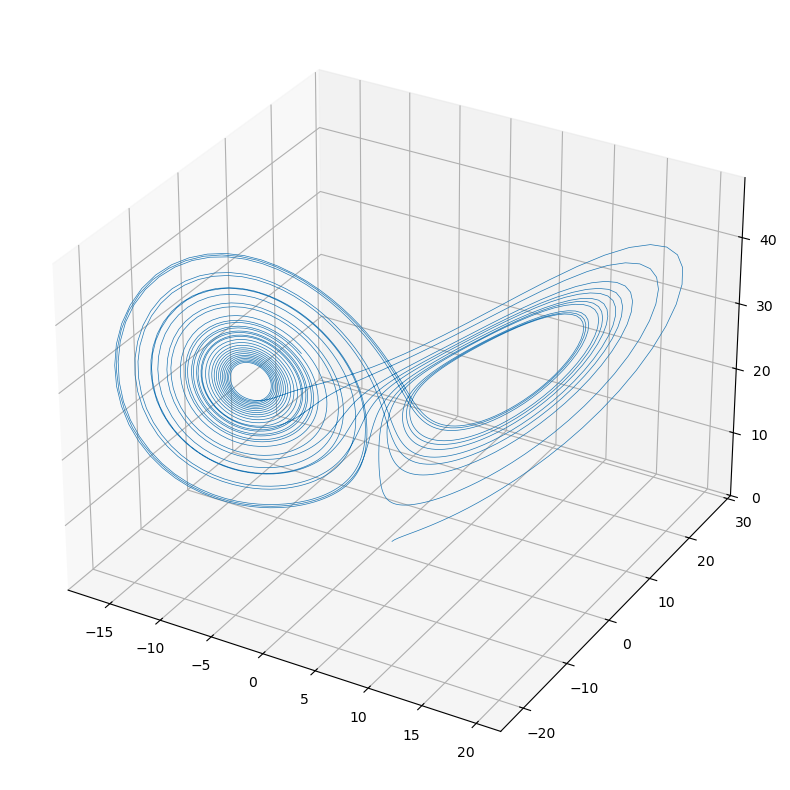

In [2]:
import matplotlib.pyplot as plt

def plot_traj(traj):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], lw=0.5)
    plt.show()

plot_traj(traj)

# 8.1.2

In [3]:
import pysindy as ps

poly_order = 6

model = ps.SINDy(
    feature_library=ps.PolynomialLibrary(degree=poly_order),
).fit(
    traj,
    t=dt,
)

traj_sim = model.simulate(traj[0, :], t_eval)

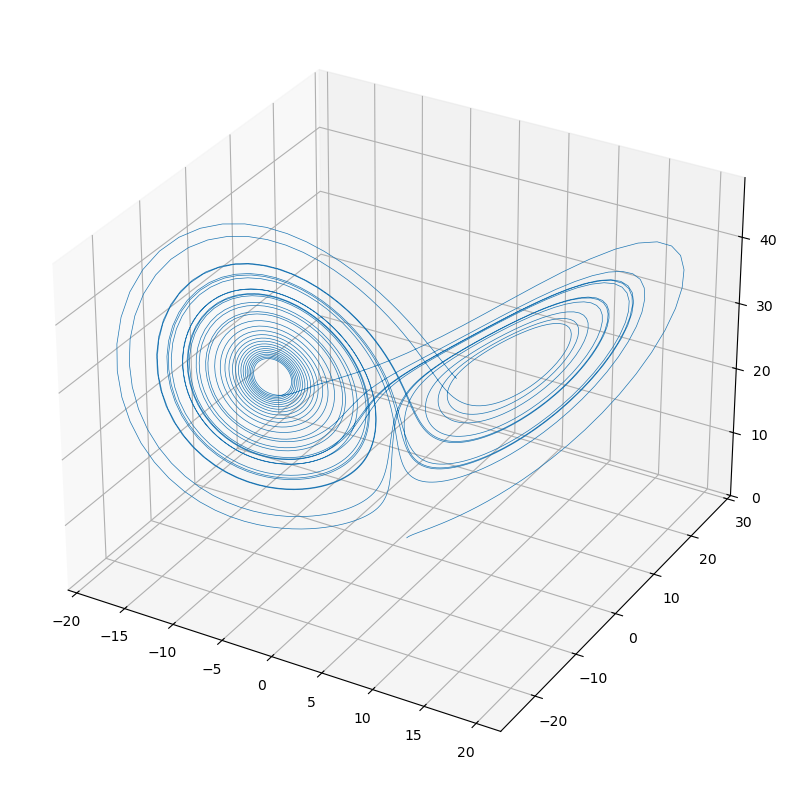

In [4]:
plot_traj(traj_sim)

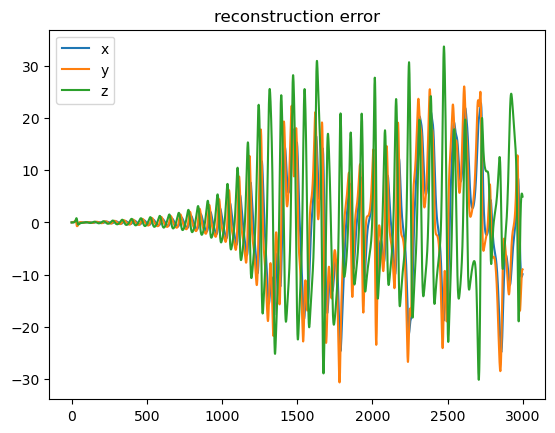

In [5]:
plt.plot((traj - traj_sim), label=["x", "y", "z"])
plt.title("reconstruction error")
plt.legend()
plt.show()

# 8.1.3

In [6]:
def fpe(model, traj, t_eval, N, first_k=None, verbose=True):
    if first_k is not None:
        traj = traj[:first_k,:]
        t_eval = t_eval[:first_k]
        
    T = traj.shape[0]
    sim = []
    res = 0
    for i in range(T - N):
        if verbose and i % int(0.1 * (T-N)) == 0:
            print("*** iter %d, %.1f%% ***" % (i, 100 * i / (T - N)))
        subtraj = model.simulate(traj[i, :], t_eval[i : i + N + 1])
        sim.append(subtraj[-1,:])

    for i in range(T - N):
        i += 1
        res += ((sim[-i] - traj[-i]) ** 2 / (T - N)).sum()

    return res

Here we use the Lyapunov time, since it's the characteristic time of the onset of the chaotic regime. Much smaller lag values won't cause noticeable deviations, while with much larger values all models will practically lose their predictive power.

In [7]:
lam = 0.9056
lyapu_N = int((1/lam) / dt)
print(lyapu_N)

110


In [ ]:
for N in [lyapu_N * i // 3 for i in range(1,6)]:
    print('MSE for N=%d:' % N)
    print(fpe(model, traj, t_eval, N))

MSE for N=36:
*** iter 0, 0.0% ***
*** iter 296, 10.0% ***
*** iter 592, 20.0% ***
*** iter 888, 30.0% ***
*** iter 1184, 39.9% ***
*** iter 1480, 49.9% ***
*** iter 1776, 59.9% ***
*** iter 2072, 69.9% ***
*** iter 2368, 79.9% ***
*** iter 2664, 89.9% ***
*** iter 2960, 99.9% ***
0.03259035667526703
MSE for N=73:
*** iter 0, 0.0% ***
*** iter 292, 10.0% ***
*** iter 584, 20.0% ***
*** iter 876, 29.9% ***
*** iter 1168, 39.9% ***
*** iter 1460, 49.9% ***
*** iter 1752, 59.9% ***
*** iter 2044, 69.8% ***
*** iter 2336, 79.8% ***
*** iter 2628, 89.8% ***
*** iter 2920, 99.8% ***
0.6265093651447092
MSE for N=110:
*** iter 0, 0.0% ***
*** iter 289, 10.0% ***
*** iter 578, 20.0% ***
*** iter 867, 30.0% ***
*** iter 1156, 40.0% ***
*** iter 1445, 50.0% ***
*** iter 1734, 60.0% ***
*** iter 2023, 70.0% ***
*** iter 2312, 80.0% ***
*** iter 2601, 90.0% ***
19.091299319002704
MSE for N=146:
*** iter 0, 0.0% ***
*** iter 285, 10.0% ***
*** iter 570, 20.0% ***
*** iter 855, 30.0% ***
*** iter 114

It's pointless to look past N=150, since we are reaching an MSE plateau, which is the upper bound given by the diameter of the attractor.

# 8.1.4